# Load data from csv files

In [2]:
import pandas as pd

burned_area = pd.read_excel('burn_data.xlsx', sheetname='Burned_Area')
temperature = pd.read_excel('burn_data.xlsx', sheetname='Temperature')
leaf_area = pd.read_excel('burn_data.xlsx', sheetname='Leaf_Area')

In [204]:
# Merge three csv files according to the column of 'system:index'
# 1. Merge "temperature" and "leaf_area" into temp_leaf by inner_join
# 2. Merge "burn_area" and temp_leaf into burned_temp_leaf by right_join
# If a csv file doesn't have matched 'system:index' value, the field value is 'nan'
# Reference link: https://datacarpentry.org/python-ecology-lesson/05-merging-data/index.html
temp_leaf = pd.merge(left=temperature, right=leaf_area, left_on='system:index', right_on='system:index') 
burned_temp_leaf = pd.merge(left=burned_area, right=temp_leaf, how='right', left_on='system:index', right_on='system:index')
print(burned_temp_leaf.columns)
#print(btl)

Index(['system:index', 'BurnDate', 'FirstDay', 'LastDay', 'QA', 'Uncertainty',
       'ppt', 'tdmean', 'tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin', 'Fpar',
       'FparExtra_QC', 'FparLai_QC', 'FparStdDev', 'Lai', 'LaiStdDev'],
      dtype='object')


In [6]:
#burned_temp_leaf.to_excel('burned_temp_leaf.xlsx')

In [205]:
# Fill in 100 for the uncertainty of date has no fire
y = burned_temp_leaf['Uncertainty'].fillna(100).values.tolist()

# Prune the unuseful columns
del burned_temp_leaf['system:index']
del burned_temp_leaf['BurnDate']
del burned_temp_leaf['FirstDay']
del burned_temp_leaf['LastDay']
del burned_temp_leaf['QA']
del burned_temp_leaf['Uncertainty']

del burned_temp_leaf['ppt']   # No contribution
del burned_temp_leaf['tdmean'] # No contribution
#del burned_temp_leaf['tmax']
del burned_temp_leaf['tmean']  # Degrade
del burned_temp_leaf['tmin']   # Degrade

#del burned_temp_leaf['vpdmax']
del burned_temp_leaf['vpdmin'] # Degrade
del burned_temp_leaf['Fpar'] # No contribution
#del burned_temp_leaf['FparExtra_QC'] # No contribution
del burned_temp_leaf['FparLai_QC'] # No contribution
del burned_temp_leaf['FparStdDev'] # No contribution
del burned_temp_leaf['Lai'] # No contribution
#del burned_temp_leaf['LaiStdDev']

X = burned_temp_leaf.values.tolist()

In [206]:
from sklearn.model_selection import train_test_split
X_fire = X[:131]
y_fire = y[:131]
X_nofire = X[132:]
y_nofire = y[132:]
X_fire_train, X_fire_test, y_fire_train, y_fire_test = train_test_split(X_fire, y_fire, test_size=0.25, random_state=42)
X_nofire_train, X_nofire_test, y_nofire_train, y_nofire_test = train_test_split(X_nofire, y_nofire, test_size=0.10, random_state=42)
#print(X_fire)
#print(y_fire)

# Regression

In [207]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=15000)
lr = lr.fit(X_fire_train, y_fire_train)

In [208]:
y_fire_pred = lr.predict(X_fire_test)
#y_nofire_pred = lr.predict(X_nofire_test)

In [209]:
import numpy as np
print(np.mean(y_fire_pred == y_fire_test))
#print(np.mean(y_nofire_pred == y_nofire_test))
#print(y_fire_pred)
#print(y_fire_test)

0.2727272727272727


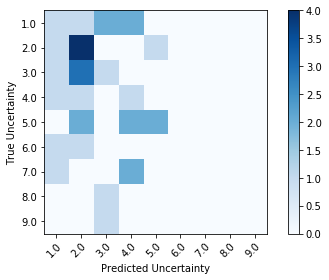

In [211]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(y_fire_test, y_fire_pred)

# Only uses the labels that appear in the data
labels = unique_labels(y_fire_test, y_fire_pred)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='True Uncertainty',
           xlabel='Predicted Uncertainty')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()